<a href="https://colab.research.google.com/github/morganmcg1/reformer-fastai/blob/main/exploration/lm_generation_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Compares Timing, Number of Trainable Parameters and Model Performance

In [1]:
# import sys
# if 'google.colab' in sys.modules:
#     !pip install -Uqq einops

In [1]:
import sys
sys.path.append("..")

import numpy as np
import torch
from torch import nn
import torch.autograd.profiler as profiler
from fastcore.all import *
from einops import rearrange

# Timing

In [2]:
def do_cuda_timing(f, inp, context=None, n_loops=100):
    f.cuda()
    inp = inp.cuda()
    if context is not None: context = context.cuda()
    with profiler.profile(record_shapes=False, use_cuda=True) as prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    if context is None: f(inp)
                    else: f(inp, context)
                    torch.cuda.synchronize()
                    
    res = round((prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
    print(f'{res}ms')
    return res

In [3]:
# Taken from fastai.callback.hook

def total_params(m):
    "Give the number of parameters of a module and if it's trainable or not"
    params = sum([p.numel() for p in m.parameters()])
    trains = [p.requires_grad for p in m.parameters()]
    return params, (False if len(trains)==0 else trains[0])

In [4]:
# OTHER PROFILER OPTIONS

# With memory
#with profiler.profile(profile_memory=True, record_shapes=True) as prof:
#     arto_encoder_layer(src)

# print(prof.key_averages().table(sort_by="self_cpu_memory_usage", row_limit=10))

# print(prof.key_averages().table(sort_by="cpu_time_total", row_limit=10))

In [5]:
# Dict to save comparisons
comparison = {}

In [6]:
# Input 
arto_src = torch.rand(64, 128, 512).cuda()
pt_src = rearrange(arto_src, 'b l e -> l b e')

pt_context = torch.rand(192, 64, 512).cuda()
arto_context = rearrange(pt_context, 'b l e -> l b e')

# Attention

Compare the Attention from baic_transformer to TorchText's new `MultiheadAttentionContainer`

### TorchText Attention

In [7]:
from torchtext.nn.modules.multiheadattention import MultiheadAttentionContainer
from torchtext.nn.modules.multiheadattention import InProjContainer
from torchtext.nn.modules.multiheadattention import ScaledDotProduct

n_loops = 500
embed_dim, num_heads, bsz, sl = 512, 8, 64, 128

in_proj_container = InProjContainer(torch.nn.Linear(embed_dim, embed_dim),
                                        torch.nn.Linear(embed_dim, embed_dim),
                                        torch.nn.Linear(embed_dim, embed_dim))

mha = MultiheadAttentionContainer(num_heads,
                                      in_proj_container,
                                      ScaledDotProduct(),
                                      torch.nn.Linear(embed_dim, embed_dim))
mha.cuda()

# query = torch.rand((21, bsz, embed_dim))
query = key = value = torch.rand((sl, bsz, embed_dim)).cuda()

with profiler.profile(record_shapes=False, use_cuda=True) as pt_prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    attn_output, attn_weights = mha(query, key, value)
                    torch.cuda.synchronize()
                    
pt_res = round((pt_prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
print(f'{pt_res}ms')

3.39ms


In [8]:
#print(pt_prof.key_averages().table(sort_by="self_cpu_time_total"))

### Arto Attention

In [13]:
from basic_transformer import Attention

arto_src = torch.rand((bsz, sl, embed_dim)).cuda()

arto_attn = Attention(512, heads=8, causal=False, dropout=0.1)
arto_attn.cuda()

with profiler.profile(record_shapes=False, use_cuda=True) as arto_prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    arto_out = arto_attn(arto_src)
                    torch.cuda.synchronize()
                    
arto_res = round((arto_prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
print(f'{arto_res}ms')

2.756ms


### Arto DecoderAttention (No Mask)

In [34]:
from basic_transformer import DecoderAttention

arto_src = torch.rand((bsz, sl, embed_dim)).cuda()

arto_dec_attn = DecoderAttention(512, heads=8, causal=False, dropout=0.1)
arto_dec_attn.cuda()

with profiler.profile(record_shapes=False, use_cuda=True) as arto_prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    arto_out = arto_dec_attn(arto_src, context=arto_context)
                    torch.cuda.synchronize()
                    
arto_dec_res = round((arto_prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
print(f'{arto_dec_res}ms')


# CAUSAL == TRUE
arto_dec_attn = DecoderAttention(512, heads=8, causal=True, dropout=0.1)
arto_dec_attn.cuda()

with profiler.profile(record_shapes=False, use_cuda=True) as arto_prof:
        with profiler.record_function("model_inference"):
            with torch.no_grad():
                for _ in range(n_loops):
                    arto_out = arto_dec_attn(arto_src, context=arto_context)
                    torch.cuda.synchronize()
                    
arto_dec_caus_res = round((arto_prof.key_averages().self_cpu_time_total / 1000) / n_loops, 3)
print(f'{arto_dec_caus_res}ms')

5.18ms
5.364ms


Log results

In [17]:
comparison['Attention'] = {'Arto': arto_res, 'pt': pt_res}

comparison['DecoderAttention'] = {'Arto': arto_dec_res, 'Arto_causakl': arto_dec_caus_res, 'pt': pt_res}

In [18]:
total_params(mha)[0], total_params(arto_attn)[0], total_params(arto_dec_attn)[0]

(1050624, 1049088, 1049088)

# Encoder 

### Encoder Layer

In [19]:
from torch.nn import TransformerEncoderLayer
from basic_transformer import TransformerEncoderBlock as artoTransformerEncoderBlock

# Pytorch
pt_encoder_layer = TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")

# ARTO
arto_encoder_layer = artoTransformerEncoderBlock(dim=512, heads=8)

Do timing

In [20]:
pt = do_cuda_timing(pt_encoder_layer, pt_src)
t = do_cuda_timing(arto_encoder_layer, arto_src)

comparison['EncoderLayer'] = {'Arto': t, 'pt': pt}

7.698ms
6.884ms


Num params

In [21]:
total_params(pt_encoder_layer)[0], total_params(arto_encoder_layer)[0]

(3152384, 3150848)

### Encoder

6-layer Encoder test

In [22]:
from torch.nn import TransformerEncoder
from basic_transformer import TransformerEncoder as artoTransformerEncoder

# Pytorch
pt_encoder_layer = TransformerEncoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")
pt_encoder = TransformerEncoder(pt_encoder_layer, num_layers=6)


# Arto
arto_encoder = artoTransformerEncoder(dim=512, depth=6, heads=8,
                                      causal=False, attn_dropout=0.1,
                                      ff_dropout=0.1)

In [23]:
pt = do_cuda_timing(pt_encoder, pt_src)
t = do_cuda_timing(arto_encoder, arto_src)

comparison['Encoder'] = {'Arto': t, 'pt': pt}

43.489ms
41.627ms


Num params

In [24]:
total_params(pt_encoder)[0], total_params(arto_encoder)[0]

(18914304, 18905088)

# Decoder

### DecoderLayer

In [29]:
from torch.nn import TransformerDecoderLayer
from basic_transformer import TransformerDecoderBlock as artoTransformerDecoderBlock
from basic_transformer import TransformerDecoderBlockV2 as artoTransformerDecoderBlockv2

# Pytorch
pt_decoder_layer = TransformerDecoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")

# ARTO
arto_decoder_layer = artoTransformerDecoderBlock(dim=512, heads=8)

# ARTO v2
arto_decoder_layer_v2 = artoTransformerDecoderBlockv2(dim=512, heads=8)

Do timing

In [30]:
pt = do_cuda_timing(pt_decoder_layer, pt_src, context=pt_context)

t = do_cuda_timing(arto_decoder_layer, arto_src, context=arto_context)
t_two = do_cuda_timing(arto_decoder_layer_v2, arto_src, context=arto_context)

comparison['DecoderLayer'] = {'Arto': t,'Artov2': t_two, 'pt': pt}

11.646ms
10.807ms
9.535ms


In [31]:
total_params(pt_decoder_layer)[0], total_params(arto_decoder_layer)[0], total_params(arto_decoder_layer_v2)[0]

(4204032, 4200960, 3150848)

Decoder vs Decoderv2 Layer sizes

In [32]:
total_params(arto_decoder_layer.ff)[0], total_params(arto_decoder_layer.attn)[0], total_params(arto_decoder_layer.cross)[0]

(2100736, 1050112, 1050112)

In [33]:
total_params(arto_decoder_layer_v2.ff)[0], total_params(arto_decoder_layer_v2.attn)[0]

(2100736, 1050112)

### Decoder

6-layer Decoder test

In [35]:
from torch.nn import TransformerDecoder
from basic_transformer import TransformerDecoder as artoTransformerDecoder

# Pytorch
pt_decoder_layer = TransformerDecoderLayer(d_model=512, nhead=8, dim_feedforward=2048, 
                                              dropout=0.1, activation="gelu")
pt_decoder = TransformerDecoder(pt_decoder_layer, num_layers=6)

# Arto
arto_decoder = artoTransformerDecoder(dim=512, depth=6, heads=8,
                                      attn_dropout=0.1, ff_dropout=0.1)

# Arto v1
arto_decoder_v2 = artoTransformerDecoder(dim=512, depth=6, heads=8,
                                      attn_dropout=0.1, ff_dropout=0.1, comb_attn=True)

In [36]:
pt = do_cuda_timing(pt_decoder, pt_src, context=pt_context)

t = do_cuda_timing(arto_decoder, arto_src, context=arto_context)

t_two = do_cuda_timing(arto_decoder_v2, arto_src, context=arto_context)

comparison['Decoder'] = {'Arto':t, 'Artov2':t_two, 'pt': pt}

68.154ms
64.875ms
57.607ms


In [37]:
total_params(pt_decoder)[0], total_params(arto_decoder)[0], total_params(arto_decoder_v2)[0]

(25224192, 25205760, 18905088)

# Timing Results

In [38]:
for k in comparison.keys():
    print(k)
    for kk in comparison[k].keys():
        print(f'{kk} : {comparison[k][kk]}ms')
    print()

Attention
Arto : 2.756ms
pt : 3.39ms

DecoderAttention
Arto : 5.21ms
pt : 3.39ms

EncoderLayer
Arto : 6.884ms
pt : 7.698ms

Encoder
Arto : 41.627ms
pt : 43.489ms

DecoderLayer
Arto : 10.807ms
Artov2 : 9.535ms
pt : 11.646ms

Decoder
Arto : 64.875ms
Artov2 : 57.607ms
pt : 68.154ms



# Training Performance

Check Perplexity performance of EncoderLM for each

In [39]:
from basic_transformer import TransformerLM
from basic_tokenizers import ByteTextTokenizer

from fastai.text.all import *
import datasets
from datasets import load_dataset
import six

### Get Data

In [40]:
from datasets.builder import FORCE_REDOWNLOAD

dataset = load_dataset('tiny_shakespeare', download_mode=FORCE_REDOWNLOAD)
train_ds = dataset['train']

def splitlines(sample):
    return {'line':[*sample['text'][0].split('\n')]}

train_ds = train_ds.map(splitlines, batched=True, remove_columns=['text'])

train_ds = train_ds.filter(lambda x: x['line'] != '')

train_ds[:10]

df = train_ds.data.to_pandas()
df.head(2)

Using custom data configuration default


Dataset tiny_shakespeare downloaded and prepared to /home/morgan/.cache/huggingface/datasets/tiny_shakespeare/default/1.0.0/da11b9a200ca715af415094b34d5c956170f184cb3a58d7789680cf81bede955. Subsequent calls will reuse this data.


,line
0,First Citizen:
1,"Before we proceed any further, hear me speak."


### Tokenizer

In [41]:
bte = ByteTextTokenizer(is_lm=True, add_bos=True, add_eos=True)

### Dataloaders

In [42]:
@patch
def create_item(self:LMDataLoader, seq):
    if seq>=self.n: raise IndexError
    sl = self.last_len if seq//self.bs==self.n_batches-1 else self.seq_len
    st = (seq%self.bs)*self.bl + (seq//self.bs)*self.seq_len
    txt = self.chunks[st : st+sl+1]    
    return LMTensorText(txt[:-1]),txt[1:]
    # return LMTensorText(txt[:-1].tolist()+[1]), LMTensorText(txt[1:].tolist()+[1])   ## ADD EOS TOKEN

cut = int(len(df)*0.8)
splits = range_of(df)[:cut], range_of(df[cut:])

tfms = [attrgetter("line"), bte]
dsets = Datasets(df, [tfms, tfms], splits=splits, dl_type=LMDataLoader)

vocab_sz = bte.vocab_size
bs,sl = 32,128
pad_seq2seq = partial(pad_input, pad_idx=bte.pad_token_id, pad_fields=[0,1])

dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=pad_seq2seq)
dls.show_batch(max_n=2)

,text,text_
0,"<bos>Whipp'd and tormented and--God-den, good fellow.<eos><bos>And give him from me this most needful scroll.<eos><bos>PARIS:<eos><bos>CATESBY:<eos><bos>And I in al","Whipp'd and tormented and--God-den, good fellow.<eos><bos>And give him from me this most needful scroll.<eos><bos>PARIS:<eos><bos>CATESBY:<eos><bos>And I in all"
1,"vereign king and queen:<eos><bos>QUEEN MARGARET:<eos><bos>Your native town you enter'd like a post,<eos><bos>She came adorned hither like sweet May,<eos><bos>If","ereign king and queen:<eos><bos>QUEEN MARGARET:<eos><bos>Your native town you enter'd like a post,<eos><bos>She came adorned hither like sweet May,<eos><bos>If"


### Arto LM

In [7]:
from basic_transformer import TransformerEmbedding
from basic_transformer import TransformerEncoder as artoTransformerEncoder

class artoTransformerLM(nn.Module):
    """
    Basic Transformer for language modelling
    Parameters:
        * vocab_sz: int
        * dim: int - inner dimension of the model
        * depth: int (default: 6) 
        * heads: int (default: 8)
        * causal: bool (default: True) - if True does causal masking automatically
        * max_seq_len: int (default: 512)
        * tie_weights: bool - if True target embedding weights are used for computation output projection
        * pos_enc: str from {'absolute', 'fixed', 'axial'} - type of positional encoding to use
    Inputs:
        * x - input ids, shape [bs, sl]
        * mask - optional boolean mask, shape [bs, sl]
    Returns:
        * logits - target token logits, shape [bs, sl, vocab_sz]
    """
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
                 max_seq_len=512, tie_weights=True, d_ff=None,
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute'):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        self.tfmr = artoTransformerEncoder(dim, depth, heads, causal=causal, d_ff=d_ff, 
                                       attn_dropout=attn_dropout,
                                       ff_dropout=ff_dropout)
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
        
    def forward(self, x, mask=None):
        x = self.emb(x)
        x = self.tfmr(x, mask=mask)
        return self.proj(x)
    #TODO maybe refactor
    @torch.no_grad()
    def generate(self, inp,
                max_len=50,
                temperature=1.,
                method = 'top_k',
                top_k = 20,
                top_p = 0.9,
                early_stopping=False):
        self.to(inp.device) #TODO test for potential problems
        self.eval()
        thresh = top_k if method=='top_k' else top_p
        sampler = _sampler[method]
        inp = expand_dim1(inp)
        b, t = inp.shape
        out = inp
        for _ in range(max_len):
            x = out[:, -self.max_seq_len:]

            logits = self(x)[:, -1, :]
            if method == 'greedy':
                sample = sampler(logits)
            else:
                filtered_logits = sampler(logits)
                probs = F.softmax(filtered_logits / temperature, dim=-1)
                sample = torch.multinomial(probs, 1)

            out = torch.cat((out, sample), dim=-1)

            if early_stopping and (sample == bte.eos_token_id).all():
                break
        # out = out[:, t:]
        return out
    # wip
    def store_attention(self):
        for m in self.modules():
            if issubclass(type(m), Attention):
                m.store_attention = True
    def get_attention_matrix(self):
        res = []
        for m in self.modules():
            if issubclass(type(m), Attention):
                attention = getattr(m, 'attention', None)
                res.append(attention)
                # reset stored attention
                m.attention = None
                m.store_attention = False
        return res

### ArtoLM Learner

In [17]:
m = artoTransformerLM(vocab_sz, 512)

arto_learn = Learner(dls, m,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0003981071640737355)

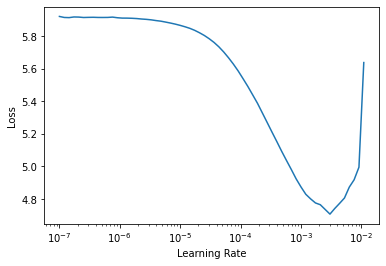

In [18]:
arto_learn.lr_find()

In [19]:
arto_learn.fit_one_cycle(1, 5e-4, wd=0.05)

epoch     train_loss  valid_loss  accuracy  perplexity  time    
0         2.454473    2.368994    0.305365  10.686633   00:31     


## Pytorch LM

In [20]:
from torch.nn import TransformerEncoder
from torch.nn import TransformerEncoderLayer

MASK_VAL = -1e4

class ptTransformerLM(artoTransformerLM):
    def __init__(self, vocab_sz, dim, depth=6, heads=8, causal=True,
             max_seq_len=512, tie_weights=True, d_ff=None,
             attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
             pos_enc='absolute'):
        super().__init__(vocab_sz, dim)
        self.max_seq_len = max_seq_len
        self.emb = TransformerEmbedding(vocab_sz, dim, max_seq_len, dropout=emb_dropout)
        
        ####
        self.pt_encoder_layer = TransformerEncoderLayer(d_model=dim, nhead=heads, dim_feedforward=2048,  ## pt ENCODER LAYER
                                                  dropout=0.1, activation="gelu")
        self.tfmr = TransformerEncoder(self.pt_encoder_layer, num_layers=depth)# .cuda().float()   ## pt ENCODER
        self.causal = causal
        self.heads = heads
        ####
        
        self.proj = nn.Linear(dim, vocab_sz)
        if tie_weights: self.proj.weight = self.emb.emb.weight
            
    
    # SWAP DIM POS FOR PYTORCH
    def forward(self, x, mask=None):
        x = self.emb(x)
        
        sl = x.size()[1]
        if self.causal:    
            mask = torch.ones((sl, sl), device = x.device).triu_(1).bool()
        x = rearrange(x, 'b l e -> l b e')
        x = self.tfmr(x, mask=mask)
        x = rearrange(x, 'l b e -> b l e')
        return self.proj(x)
    

In [21]:
pt_model = ptTransformerLM(vocab_sz, 512)

In [22]:
pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

SuggestedLRs(lr_min=0.03019951581954956, lr_steep=0.25118863582611084)

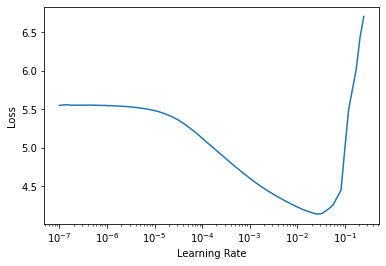

In [23]:
pt_learn.lr_find()

In [24]:
pt_learn.fit_one_cycle(1, 4e-5, wd=0.05)

epoch     train_loss  valid_loss  accuracy  perplexity  time    
0         3.271894    3.125577    0.216484  22.773037   00:31     


### Do Average Performance comparison

Model Parameters

Pytorch has more params due to unused `pt_encoder_layer` which is just used to create the encoder

In [25]:
total_params(pt_learn.model)[0], total_params(arto_learn.model)[0]

(22461699, 19300099)

Timing Comparison

In [26]:
def model_performance(n_loops=5, model='arto', dls=None, n_epochs=1, lr=5e-4):
    acc_ls, ppl_ls =[], []
    for i in range(n_loops):
        if model == 'arto': m = artoTransformerLM(vocab_sz, 512)
        elif model == 'pt': m = ptTransformerLM(vocab_sz, 512)
        else: print('model name not correct')
        
        learn = Learner(dls, m,
                    loss_func=CrossEntropyLossFlat(),
                    metrics=[accuracy, Perplexity()]).to_native_fp16()

        learn.fit_one_cycle(n_epochs, lr, wd=0.05)
        
        acc_ls.append(learn.recorder.final_record[2])
        ppl_ls.append(learn.recorder.final_record[3])
    print(f'Avg Accuracy: {round(sum(acc_ls)/len(acc_ls),3)}, std: {np.std(acc_ls)}')
    print(f'Avg Perplexity: {round(sum(ppl_ls)/len(ppl_ls),3)}, std: {np.std(ppl_ls)}')
    print()
    return learn, acc_ls, ppl_ls

Arto

In [27]:
arto_learn, arto_acc_ls, arto_ppl_ls = model_performance(n_loops=7, model='arto', dls=dls, n_epochs=15, lr=5e-4)

epoch     train_loss  valid_loss  accuracy  perplexity  time    
0         2.729918    2.490288    0.279258  12.064751   00:31     
1         2.437726    2.384522    0.301265  10.853878   00:31     
2         2.226103    2.133438    0.370601  8.443844    00:31     
3         1.946830    1.825802    0.456324  6.207771    00:30     
4         1.739669    1.648017    0.500166  5.196667    00:30     
5         1.617353    1.530428    0.534025  4.620153    00:30     
6         1.535049    1.448661    0.554046  4.257410    00:31     
7         1.473559    1.398566    0.568216  4.049389    00:31     
8         1.423877    1.358346    0.577938  3.889752    00:30     
9         1.390191    1.316350    0.588158  3.729781    00:30     
10        1.352883    1.291742    0.595815  3.639121    00:30     
11        1.332584    1.266773    0.601703  3.549381    00:30     
12        1.306724    1.253637    0.605487  3.503062    00:30     
13        1.296162    1.247478    0.607914  3.481553    00:30   

Pytorch

In [18]:
pt_learn, pt_acc_ls, pt_ppl_ls = model_performance(n_loops=7, model='pt', dls=dls, n_epochs=15, lr=5e-4)

epoch     train_loss  valid_loss  accuracy  perplexity  time    
0         2.937238    2.551770    0.283704  12.829795   00:31     
1         2.341835    2.211590    0.355974  9.130218    00:30     
2         1.972779    1.839023    0.451645  6.290387    00:31     
3         1.718368    1.611390    0.509064  5.009770    00:31     
4         1.579673    1.487297    0.543451  4.425117    00:31     
5         1.495771    1.413877    0.561926  4.111867    00:31     
6         1.437492    1.360043    0.577840  3.896359    00:31     
7         1.390486    1.314164    0.589124  3.721638    00:31     
8         1.354231    1.277807    0.598650  3.588760    00:31     
9         1.319744    1.245034    0.607840  3.473053    00:31     
10        1.285656    1.222012    0.612911  3.394011    00:31     
11        1.265460    1.198145    0.621247  3.313962    00:30     
12        1.242040    1.184194    0.624083  3.268051    00:31     
13        1.230900    1.178317    0.626560  3.248903    00:31   

Performance Results

ARTO:

- Avg Accuracy: 0.608, std: 0.001348531716878969
- Avg Perplexity: 3.485, std: 0.01

PT:

- Avg Accuracy: 0.626, std: 0.0008662468796634467
- Avg Perplexity: 3.255, std: 0.009614346466018758

## Generation

In [29]:
# credit https://github.com/huggingface/transformers/blob/a0c62d249303a68f5336e3f9a96ecf9241d7abbe/src/transformers/generation_logits_process.py
def top_p_filter(logits, top_p=0.9):
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cum_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

    sorted_indices_to_remove = cum_probs > top_p
    sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
    sorted_indices_to_remove[..., 0] = 0
    # if min_tokens_to_keep > 1:
    #         # Keep at least min_tokens_to_keep (set to min_tokens_to_keep-1 because we add the first one below)
    #         sorted_indices_to_remove[..., : min_tokens_to_keep - 1] = 0
    indices_to_remove = sorted_indices_to_remove.scatter(1, sorted_indices, sorted_indices_to_remove)
    scores[indices_to_remove] = float('-inf')
    return scores

def top_k_filter(logits, top_k=20):
    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    logits[indices_to_remove] = float('-inf')
    return logits

_sampler = {
    'top_k':top_k_filter,
    'top_p':top_p_filter,
    'gready':lambda x: x.argmax(-1)
}

@torch.no_grad()
def generate(model,
             inp,
             max_len=50,
             temperature=1.,
             method = 'top_k',
             top_k = 20,
             top_p = 0.9,
             early_stopping=False):
    model.eval()
    thresh = top_k if method=='top_k' else top_p
    sampler = _sampler[method]

    if len(inp.shape) == 1:
        inp = inp[None, :]
    b, t = inp.shape
    out = inp
    
    for _ in range(max_len):
        x = out[:, -model.max_seq_len:]

        logits = model(x)[:, -1, :]
        if method == 'greedy':
            sample = sampler(logits)
        else:
            filtered_logits = sampler(logits)
            probs = F.softmax(filtered_logits / temperature, dim=-1)
            sample = torch.multinomial(probs, 1)

        out = torch.cat((out, sample), dim=-1)

        if early_stopping and (sample == bte.eos_token_id).all():
            break
    # out = out[:, t:]
    return out

In [31]:
# out = generate(arto_learn.model, tensor([[2]]).cuda(),
#                max_len = 100,
#                early_stopping=False,
#                temperature=1.)

# [bte.decode(x.cpu().tolist()) for x in out]

In [32]:
# out = generate(pt_learn.model, tensor([[2]]).cuda(),
#                max_len = 100,
#                early_stopping=False,
#                temperature=1.)

# [bte.decode(x.cpu().tolist()) for x in out]

# Encoder-Decoder Test

In [1]:
import sys
sys.path.append("..")

from basic_transformer import TransformerEncDec
from basic_tokenizers import ByteTextTokenizer
from helpers import total_params

from fastai.text.all import *
from fastai.basics import *

No module named 'axial_positional_embedding'


In [2]:
path = Path('..')
df = pd.read_csv(path/'en_ga_prep.csv', index_col=0)
df.head()

,clean,en,en_len,ga,ga_len
0,True,"Among the French PIM , in 2013, it is only 9 islands that have been chiroptérologiques inventories .",18,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
1,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince , i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail .",18
2,True,"Among the French PIM, in 2013, it is only 9 islands that have been chiroptérologiques inventories.",16,"I measc na PIM Fraince, i 2013, tá sé ach 9 oileáin a bhí chiroptérologiques fardail.",16
3,True,"As you can see, so get to show off the spacious shapes in 3D (red and blue).",17,"Mar is féidir leat a fheiceáil, a fháil mar sin a thaispeáint as na cruthanna mhór i 3D (dearg agus gorm).",21
4,True,"Equation Solving – Traditional, simple",5,"Ligningsløsning – Traidisiúnta, simplí",4


In [3]:
#df = df[:32]

def add_eos(text):
    return text + f' {EOS}'

dblock = DataBlock(blocks=(TextBlock.from_df('en', tok_text_col='en', rules=[add_eos]),
                           TextBlock.from_df('ga', tok_text_col='ga', rules=[add_eos])),
                   get_x=ColReader('en'),
                   get_y=ColReader('ga'), 
                   splitter=RandomSplitter())

dsets = dblock.datasets(df)

pad_seq2seq = partial(pad_input, pad_fields=[0,1])

dls = dsets.dataloaders(bs=16, dl_type=SortedDL, before_batch=pad_seq2seq)
dls.show_batch(max_n=4)

/home/morgan/anaconda3/envs/fastai_env/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"3 . —(1 ) The Seventh Schedule to the Act of 1952 , which contains rules as to calculation of means for the purposes of old age pension , is hereby amended by the substitution in Rule 1 ( II ) ( h ) of “ £ 208 ” , “ £ 156 ” and “ £ 104 ” , respectively , for “ £ 65 ” , “ £ 52 ” and “ £ 39 ” ( inserted by the Act of 1965 ) in both places where they occur . xxeos","3 . —(1 ) Leasaítear leis seo an Seachtú Sceideal a ghabhann le hAcht 1952 , ina bhfuil rialacha faoi ríomh acmhainne chun críocha pinsin seanaoise , trí “ £ 208 ” , “ £ 156 ” agus “ £ 104 ” , faoi seach , a chur i Riail 1 ( II ) ( h ) in ionad “ £ 65 ” , “ £ 52 ” agus “ £ 39 ” ( a cuireadh isteach le hAcht 1965 ) sa dá áit a bhfuil siad . xxeos"
1,"“ ( 2 ) The Minister shall not exercise , in respect of any land , either the right conferred on him by paragraph ( a ) of subsection ( 1 ) of this section or the power conferred on him by paragraph ( b ) of the said subsection unless , at least twenty - one days before exercising that right or that power , as the case may be,— xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","“ ( 2 ) Ní fheidhmeoidh an tAire , maidir le haon talamh , an ceart a thugtar dó le mír ( a ) d'fho - alt ( 1 ) den alt seo ná an chumhacht a thugtar dó le mír ( b ) den fho - alt sin , muran rud é , lá agus fiche ar a laghad sula bhfeidhmeoidh sé an ceart nó an chumhacht sin , de réir mar a xxunk xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"( b ) For the purposes of paragraph ( a ) of this subsection , a person who has been absent without authority for a continuous period of six months or more shall , unless the contrary is proved , be presumed to have had the intention of not returning to his unit or formation or the place where his duty requires him to be . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( b ) Chun críocha míre ( a ) den fho - alt seo , aon duine a bheas as láthair gan údarás ar feadh sé mhí nó níos mó as a chéile , measfar , mura gcruthaítear a mhalairt , go raibh ar intinn ag an duine sin gan filleadh ar a aonad , ar a eagar nó ar an áit arb ann atá a dhualgas . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,"( ii ) that the person who imported the goods knew , or ought reasonably to have known , that the person who exported the goods exported goods on other occasions for the purpose of dumping them and that the dumping was of a kind which , if it occurred in the State , would cause material injury to an industry in the State , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","( ii ) go raibh a fhios ag an duine a d'allmhairigh na hearraí , nó gur cheart , le réasún , fios a bheith aige , go ndearna an duine a d'onnmhairigh na hearraí earraí a onnmhairiú ar ócáidí eile lena xxunk agus gur dhumpáil í , dá dtarlódh sí sa Stát , a dhéanfadh díobháil ábhartha do thionscal sa Stát , xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"


In [4]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def before_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS when it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def before_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

In [5]:
en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768

xb, yb = dls.one_batch()
xb.shape, yb.shape

((16, 93), (16, 89))

### Standard EncDec Attention

In [62]:
# %debug model(xb, yb[:,:-1])

cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]


enc_dec_model = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None)

arto_encdec_learn = Learner(dls, enc_dec_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_fp16()

In [63]:
total_params(arto_encdec_learn.model)[0]

157406200

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.0831763744354248)

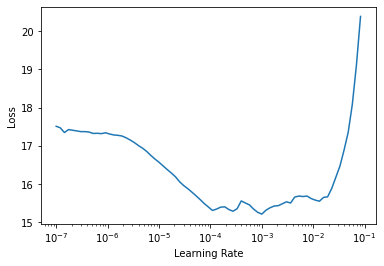

In [64]:
arto_encdec_learn.lr_find()

In [9]:
arto_encdec_learn.fit_one_cycle(3, 5e-5)  #  3e-5

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         nan         nan         0.008778  0.007206     27:09     
1         nan         nan         0.008778  0.007206     23:21     
2         nan         nan         0.008778  0.007206     23:41     
3         nan         nan         0.008778  0.007206     23:55     
4         nan         nan         0.008778  0.007206     24:03     


In [10]:
arto_encdec_learn.recorder.final_record

(#4) [nan,nan,0.008777979761362076,0.007206014449685744]

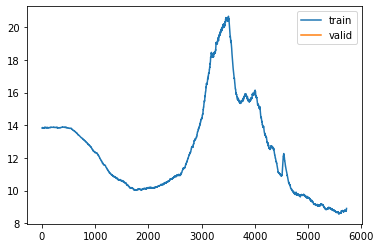

In [11]:
arto_encdec_learn.recorder.plot_loss()

### Combined Attention Test

In [6]:
import wandb
from fastai.callback.wandb import *

WANDB_NAME = 'comb_attn'
GROUP = 'TEST'     # Group to add a run to, e.g. "LSH" for LSH experiments, "REVERSIBLE" for reversible layers
NOTES = 'Testing combined attention performance'
CONFIG = {}
TAGS =['comb_attn','test']

wandb.init(reinit=True, project="reformer-fastai", entity="fastai_community", 
           name=WANDB_NAME, group=GROUP, notes=NOTES,  tags=TAGS) 

wandb: Currently logged in as: morgan (use `wandb login --relogin` to force relogin)


In [7]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback(), WandbCallback(log_model=False, log_preds=False)]

enc_dec_model_v2 = TransformerEncDec(en_vocab_sz, ga_vocab_sz, dim=d_model, depth=6, heads=8, 
                 max_seq_len=256, pad_idx=dls.o2i[0][PAD], tie_weights=True, 
                 attn_dropout=0.1, ff_dropout=0.1, emb_dropout=0.1,
                 pos_enc='absolute', d_ff=None, comb_attn=True)

arto_encdec_learn_v2 = Learner(dls, enc_dec_model_v2,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_native_fp16()

In [8]:
total_params(arto_encdec_learn_v2.model)[0]

143236600

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.02754228748381138)

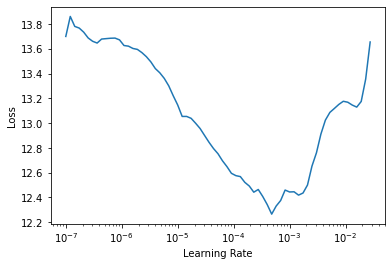

In [9]:
arto_encdec_learn_v2.lr_find()

In [ ]:
arto_encdec_learn_v2.fit_one_cycle(3, 1e-4, div=5)  

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    
0         2.885687    2.746036    0.418986  0.216402     28:35     
1         2.192592    2.023778    0.506025  0.319416     28:53     


In [ ]:
arto_encdec_learn_v2.recorder.final_record

In [ ]:
arto_encdec_learn_v2.recorder.plot_loss()

### PyTorch Transformer Test

In [ ]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        #inp = torch.ger(pos, self.freq)
        inp = torch.ger(pos, self.freq.float())
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc
    
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        #pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        pos = torch.arange(0, inp.size(1), device=inp.device).float()     
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

    
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1, fp16=True):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        self.fp16 = fp16
        # !!!
        #self.final.weight = self.dec_tfmr_emb.embed.weight    # !! What does this do?
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation='relu', custom_encoder=None, custom_decoder=None)
    
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        # Test whether fp16 is being used or not
        if not isinstance(model.transformer_model.encoder.layers[0].self_attn.out_proj.weight,
                          torch.cuda.FloatTensor):
            enc_emb=to_half(enc_emb)
            dec_emb=to_half(dec_emb)
        
        src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        
        return out.permute(1,0,2)


In [ ]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 

en_vocab_sz = len(dls.vocab[0])
ga_vocab_sz = len(dls.vocab[1])
d_model = 768
n_heads=8 #12
d_inner=2048  #1024

In [6]:
cbs = [CombineInputOutputCallback(), RemoveEOSCallback(dls.o2i[0][EOS]), LossTargetShiftCallback()]

pt_model=pt_Transformer(src_vcbsz=n_x_vocab, trg_vcbsz=n_y_vocab, d_model=d_model, d_inner=d_inner)

pt_learn = Learner(dls, pt_model,
                loss_func=CrossEntropyLossFlat(ignore_index=1), cbs=cbs,
                metrics=[accuracy, CorpusBLEUMetric()]).to_fp16()

In [7]:
total_params(pt_learn.model)[0]

157406200

SuggestedLRs(lr_min=0.012022644281387329, lr_steep=0.10000000149011612)

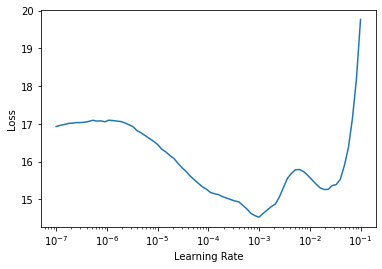

In [8]:
pt_learn.lr_find()

In [ ]:
pt_learn.fit_one_cycle(2, 5e-5)  #  3e-5

epoch     train_loss  valid_loss  accuracy  corpus_bleu  time    


In [ ]:
pt_learn.recorder.final_record

In [ ]:
pt_learn.recorder.plot_loss()

# Check Attention Masking

In [58]:
from basic_transformer import *

@patch
def forward(self:Attention, x, context = None, mask = None, context_mask = None, store_attention=False):
    b, n, _, h, device = *x.shape, self.heads, x.device
    kv_input = default(context, x)

    q = self.to_q(x) # replaced q_ with q (don't need to store it fore basic tfmr)
    kv = self.to_kv(kv_input).chunk(2, dim = -1)

    q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), (q, *kv))
    # boolean input_mask is False at positions not to attend to
    input_mask = None
    if any(map(exists, (mask, context_mask))):
        q_mask = default(mask, lambda: torch.ones((b, n), device = device).bool())
        k_mask = q_mask if not exists(context) else context_mask
        k_mask = default(k_mask, lambda: torch.ones((b, k.shape[-2]), device = device).bool())
        q_mask = rearrange(q_mask, 'b i -> b () i ()')
        k_mask = rearrange(k_mask, 'b j -> b () () j')
        input_mask = q_mask * k_mask
    # classic dot-product attention
    dots = torch.einsum('bhid,bhjd->bhij', q, k) * self.scale
    # might need to tune MASK_VAL for fp16 to work
    if exists(input_mask):
        dots.masked_fill_(~input_mask, MASK_VAL)
        del input_mask

    if self.causal:
        i, j = dots.shape[-2:]
        mask = torch.ones((i, j), device = device).triu_(j - i + 1).bool()
        print(mask.sum(1))
        print(mask[0])
        print(mask[-1])
        print()
        dots.masked_fill_(mask, MASK_VAL)
        del mask

    attn = F.softmax(dots, -1)
    if self.store_attention: # and not self.training
        self.attention = attn.detach().cpu()
    attn = self.dropout(attn)

    out = torch.einsum('bhij,bhjd->bhid', attn, v)
    out = rearrange(out, 'b h n d -> b n (h d)')
    out =  self.to_out(out)
    #out = self.dropout(out) # option for more dropout here
    return out

In [59]:
m = artoTransformerLM(vocab_sz, 512)

learn = Learner(dls, m,
                loss_func=CrossEntropyLossFlat(),
                metrics=[accuracy, Perplexity()]).to_native_fp16()

tensor([127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114,
        113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100,
         99,  98,  97,  96,  95,  94,  93,  92,  91,  90,  89,  88,  87,  86,
         85,  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,
         71,  70,  69,  68,  67,  66,  65,  64,  63,  62,  61,  60,  59,  58,
         57,  56,  55,  54,  53,  52,  51,  50,  49,  48,  47,  46,  45,  44,
         43,  42,  41,  40,  39,  38,  37,  36,  35,  34,  33,  32,  31,  30,
         29,  28,  27,  26,  25,  24,  23,  22,  21,  20,  19,  18,  17,  16,
         15,  14,  13,  12,  11,  10,   9,   8,   7,   6,   5,   4,   3,   2,
          1,   0], device='cuda:0')
tensor([False,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,

SuggestedLRs(lr_min=0.0003019951749593019, lr_steep=0.0003311311302240938)

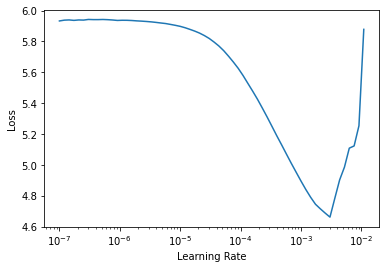

In [60]:
learn.lr_find()